## Importing the libraries

In [63]:
import copy
import gc
import random
from datetime import datetime
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import shap
import torch
import torch.nn.functional as F
import umap.umap_ as umap
from lime import lime_image
from PIL import Image
from skimage.color import gray2rgb, label2rgb, rgb2gray
from skimage.segmentation import mark_boundaries
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from skorch import NeuralNetClassifier
from torch import nn
from torch.autograd import Variable
from torchvision import datasets, transforms
from xgboost import XGBClassifier

from load_mnist import load_mnist

# check to see if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
RANDOM_STATE = 10
# Set this as per your processor cores
N_JOBS = 4
gc.collect()

0

## Using XGbost and Random Forest

## 1. Loading the data

In [55]:
X_train, y_train = load_mnist("fmnist_data/FashionMNIST/raw/", kind="train")
X_test, y_test = load_mnist("fmnist_data/FashionMNIST/raw/", kind="t10k")

labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

# Converting into dataframes
df_X_train = pd.DataFrame(X_train)
df_y_train = pd.DataFrame(y_train)

df_X_test = pd.DataFrame(X_test)
df_y_test = pd.DataFrame(y_test)

df_X_train = df_X_train.add_prefix("pixel_")

# Creating a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    stratify=y_train,  # To get balanced data by classes in two datasets.
    test_size=0.1,
    random_state=RANDOM_STATE,
)

## 2. Data Exploration
- Looking at the dimention of the data, seems like the images are flattened.
- Each image is represented as a row with 784 columns (28 * 28 = 784), each column containing a pixel density.


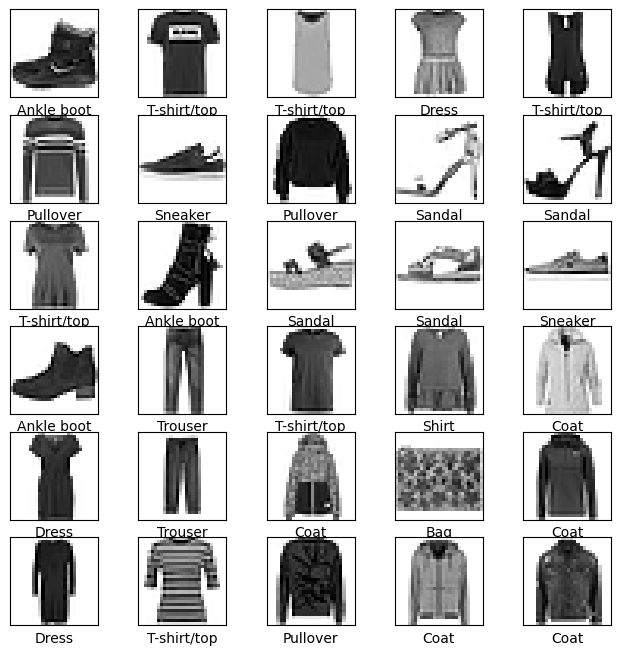

In [43]:
plt.figure(figsize=(8, 8))
# Show only the first 30 pictures
for i in range(30):
    plt.subplot(6, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(labels[y_train[i]])

## 3. Dimensionality Reduction
We are using 2 methods of dimensinality reduction:
1. UMAP (Uniform Manifold Approximation and Projection):
    UMAP is a dimension reduction technique that can be used for visualisation.

2. TSNE (t-distributed Stochastic Neighbor Embedding):
    TSNE is an unsupervised non-linear dimensionality reduction technique for data exploration and visualizing high-dimensional data.


In [54]:
# Dimensionality Reduction using UMAP
umap_reduce = umap.UMAP(random_state=RANDOM_STATE, n_jobs=N_JOBS)
df_X_train_embedding = umap_reduce.fit_transform(
    df_X_train
)  ## Takes 3-4 minutes to fit
df_X_train_embedding["class"] = y_train
df_X_train_embedding["class"].replace(labels, inplace=True)

# Visualization
sns.set_style("whitegrid", {"axes.grid": False})
ax = sns.pairplot(
    x_vars=[0],  # column 0
    y_vars=[1],  # column 1
    data=df_X_train_embedding,
    hue="class",
    height=10,
    plot_kws={"s": 5},
)
ax.fig.suptitle("Fashion MNIST clustered with UMAP")

n_jobs value 4 overridden to 1 by setting random_state. Use no seed for parallelism.


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

The figure layout has changed to tight


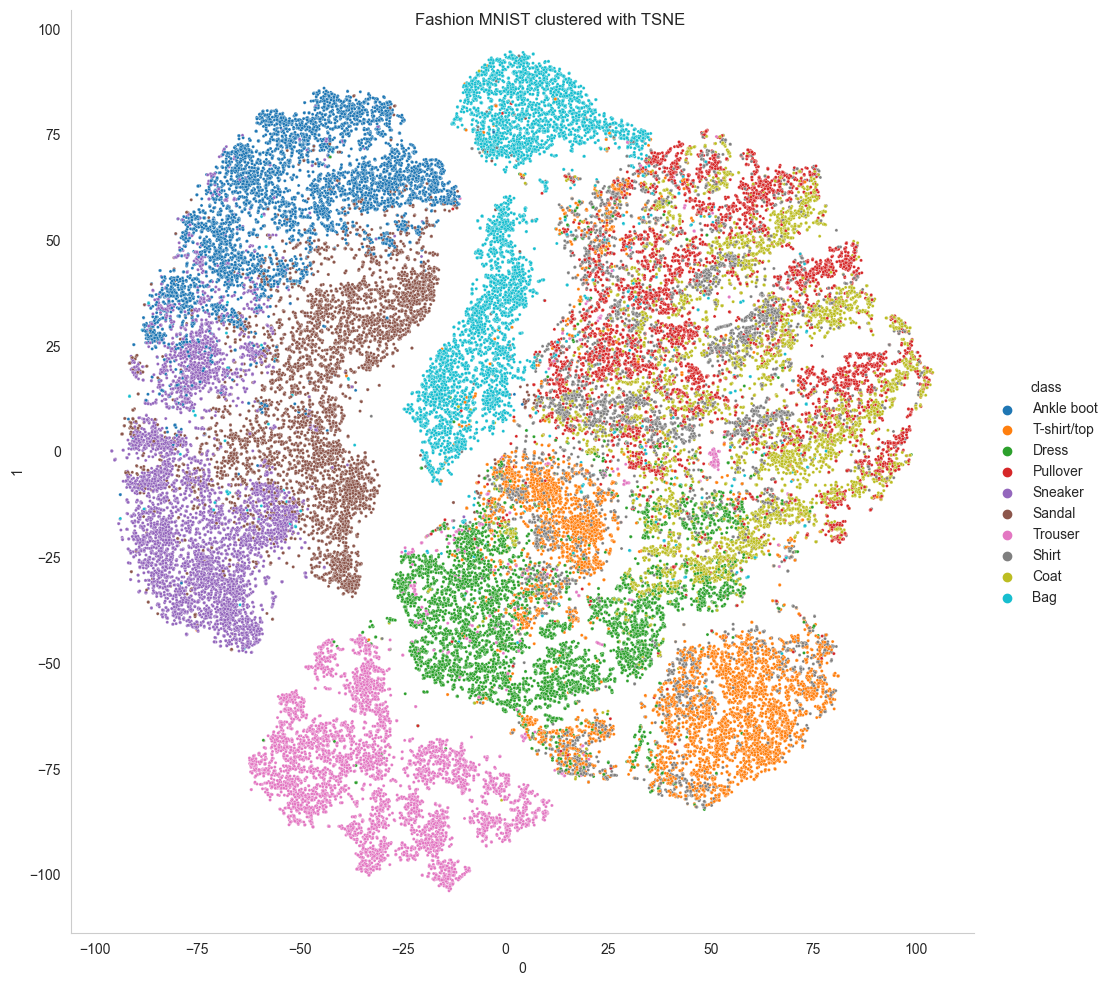

In [47]:
tsne_reduce = TSNE(random_state=RANDOM_STATE, n_jobs=N_JOBS)
df_X_train_tsne = tsne_reduce.fit_transform(X_train)  # Takes 3-4 minutes to fit

df_X_train_tsne = pd.DataFrame(df_X_train_tsne)
df_X_train_tsne["class"] = y_train
df_X_train_tsne["class"].replace(labels, inplace=True)
df_X_train_tsne.head()

sns.set_style("whitegrid", {"axes.grid": False})

# adjusting plot dots with plot_kws
ax = sns.pairplot(
    x_vars=[0],  # column 0
    y_vars=[1],  # column 1
    data=df_X_train_tsne,
    hue="class",
    height=10,
    plot_kws={"s": 5},
)

ax.fig.suptitle("Fashion MNIST clustered with TSNE")

By above plot we can observe similarity between T-shirt/top, Pullover, Shirt, and Coat, when represented in 2-dim.

## XGBoost Classifier

In [56]:
# XGBoost Classifier
xgb_base = XGBClassifier(
    random_state=RANDOM_STATE, n_jobs=N_JOBS, early_stopping_rounds=10, verbosity=1
)
xgb_base.fit(X_train, y_train, eval_set=[(X_val, y_val)])
print("Minimum Validation loss : ", xgb_base.best_score)
print("Best optimization iteration : ", xgb_base.best_iteration)

# Prediction on the train data
y_pred_train_xgb_base = xgb_base.predict(X_train)
print("Accuracy on train set : ", accuracy_score(y_train, y_pred_train_xgb_base))
print("\n")
print(
    "Confustion Matrix on train set : \n",
    confusion_matrix(y_train, y_pred_train_xgb_base),
)
print("\n")
print(
    "Classification Report on train set : \n",
    classification_report(y_train, y_pred_train_xgb_base),
)

# Prediction on the test data
y_pred_test_xgb_base = xgb_base.predict(X_test)
print("Accuracy on test set : ", accuracy_score(y_test, y_pred_test_xgb_base))
print("\n")
print(
    "Confustion Matrix on test set : \n",
    confusion_matrix(y_test, y_pred_test_xgb_base),
)
print("\n")
print(
    "Classification Report on test set : \n",
    classification_report(y_test, y_pred_test_xgb_base),
)

[0]	validation_0-mlogloss:1.40310
[1]	validation_0-mlogloss:1.10439
[2]	validation_0-mlogloss:0.91520
[3]	validation_0-mlogloss:0.78405
[4]	validation_0-mlogloss:0.68618
[5]	validation_0-mlogloss:0.61183
[6]	validation_0-mlogloss:0.55542
[7]	validation_0-mlogloss:0.50938
[8]	validation_0-mlogloss:0.47368
[9]	validation_0-mlogloss:0.44461
[10]	validation_0-mlogloss:0.42202
[11]	validation_0-mlogloss:0.40368
[12]	validation_0-mlogloss:0.38721
[13]	validation_0-mlogloss:0.37336
[14]	validation_0-mlogloss:0.36275
[15]	validation_0-mlogloss:0.35236
[16]	validation_0-mlogloss:0.34418
[17]	validation_0-mlogloss:0.33629
[18]	validation_0-mlogloss:0.33069
[19]	validation_0-mlogloss:0.32473
[20]	validation_0-mlogloss:0.31884
[21]	validation_0-mlogloss:0.31336
[22]	validation_0-mlogloss:0.30917
[23]	validation_0-mlogloss:0.30592
[24]	validation_0-mlogloss:0.30242
[25]	validation_0-mlogloss:0.29939
[26]	validation_0-mlogloss:0.29686
[27]	validation_0-mlogloss:0.29404
[28]	validation_0-mlogloss:0.2

## Random Forest Classifier

In [57]:
# Random Forest Classifier
rf_base = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS, verbose=1)
rf_base.fit(X_train, y_train)  # Takes around 1 minute

# Prediction on the train data
y_pred_train_rf_base = rf_base.predict(X_train)
print("Accuracy on train set : ", accuracy_score(y_train, y_pred_train_rf_base))
print("\n")
print(
    "Confustion Matrix on train set : \n",
    confusion_matrix(y_train, y_pred_train_rf_base),
)
print("\n")
print(
    "Classification Report on train set : \n",
    classification_report(y_train, y_pred_train_rf_base),
)

# Prediction on the test data
y_pred_test_rf_base = rf_base.predict(X_test)
print("Accuracy on test set : ", accuracy_score(y_test, y_pred_test_rf_base))
print("\n")
print(
    "Confustion Matrix on test set : \n",
    confusion_matrix(y_test, y_pred_test_rf_base),
)
print("\n")
print(
    "Classification Report on test set : \n",
    classification_report(y_test, y_pred_test_rf_base),
)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   11.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s


Accuracy on train set :  1.0


Confustion Matrix on train set : 
 [[5400    0    0    0    0    0    0    0    0    0]
 [   0 5400    0    0    0    0    0    0    0    0]
 [   0    0 5400    0    0    0    0    0    0    0]
 [   0    0    0 5400    0    0    0    0    0    0]
 [   0    0    0    0 5400    0    0    0    0    0]
 [   0    0    0    0    0 5400    0    0    0    0]
 [   0    0    0    0    0    0 5400    0    0    0]
 [   0    0    0    0    0    0    0 5400    0    0]
 [   0    0    0    0    0    0    0    0 5400    0]
 [   0    0    0    0    0    0    0    0    0 5400]]


Classification Report on train set : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5400
           1       1.00      1.00      1.00      5400
           2       1.00      1.00      1.00      5400
           3       1.00      1.00      1.00      5400
           4       1.00      1.00      1.00      5400
           5       1.00      1.00    

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


## Hyperparameter Tuning and Optimization 

In [58]:
xgb_grid_parameters = {
    "max_depth": [5],
    "n_estimators": [100],
    "early_stopping_rounds": [10],
    "reg_lambda": [0.001, 0.01, 0.1, 1, 10],  # L2/ Ridge regularization
    "colsample_bytree": [0.8, 0.9],
}

kFold = StratifiedKFold(n_splits=6)

xgb_model_gs01 = GridSearchCV(
    estimator=XGBClassifier(
        random_state=RANDOM_STATE,
        verbose=1,
        early_stopping_rounds=10,
        tree_method="gpu_hist",
        predictor="gpu_predictor",
        device="cuda",
        gpu_id=0,
    ),
    param_grid=xgb_grid_parameters,
    cv=kFold,
    scoring="f1_weighted",
    n_jobs=N_JOBS,
    verbose=1,
)

xgb_model_gs01.fit(X_train, y_train, eval_set = [(X_val, y_val)]) # Takes around 1 hr
print("Best Parameters as per grid search : ", xgb_model_gs01.best_params_)

Fitting 6 folds for each of 10 candidates, totalling 60 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


ValueError: 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:02] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000128890998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001289303b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012892fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x00000001289d7fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x00000001288b04c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001032e804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001032e5834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x00000001032c8140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001032c24a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:02] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000012e80c998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000012e8ac3b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012e8abee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x000000012e953fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x000000012e82c4c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x0000000102c9804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000102c95834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000102c78140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000102c724a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:02] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001286f0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001287903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012878fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000128837fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x00000001287104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x000000010562c04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000105629834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000105044140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010503e4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:02] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000126ef0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000126f903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x0000000126f8fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000127037fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x0000000126f104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001037e804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001037e5834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000103200140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001031fa4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:03] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000126ef0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000126f903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x0000000126f8fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000127037fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x0000000126f104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001037e804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001037e5834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000103200140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001031fa4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:03] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000128890998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001289303b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012892fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x00000001289d7fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x00000001288b04c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001032e804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001032e5834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x00000001032c8140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001032c24a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:03] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001286f0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001287903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012878fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000128837fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x00000001287104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x000000010562c04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000105629834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000105044140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010503e4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:03] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000012e80c998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000012e8ac3b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012e8abee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x000000012e953fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x000000012e82c4c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x0000000102c9804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000102c95834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000102c78140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000102c724a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:05] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001286f0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001287903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012878fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000128837fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x00000001287104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x000000010562c04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000105629834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000105044140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010503e4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:05] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000012e80c998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000012e8ac3b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012e8abee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x000000012e953fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x000000012e82c4c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x0000000102c9804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000102c95834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000102c78140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000102c724a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:05] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000126ef0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000126f903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x0000000126f8fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000127037fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x0000000126f104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001037e804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001037e5834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000103200140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001031fa4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:05] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000128890998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001289303b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012892fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x00000001289d7fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x00000001288b04c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001032e804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001032e5834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x00000001032c8140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001032c24a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:06] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000012e80c998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000012e8ac3b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012e8abee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x000000012e953fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x000000012e82c4c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x0000000102c9804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000102c95834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000102c78140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000102c724a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:06] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000128890998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001289303b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012892fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x00000001289d7fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x00000001288b04c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001032e804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001032e5834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x00000001032c8140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001032c24a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:06] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001286f0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001287903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012878fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000128837fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x00000001287104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x000000010562c04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000105629834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000105044140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010503e4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:06] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000126ef0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000126f903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x0000000126f8fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000127037fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x0000000126f104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001037e804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001037e5834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000103200140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001031fa4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:07] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000012e80c998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000012e8ac3b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012e8abee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x000000012e953fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x000000012e82c4c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x0000000102c9804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000102c95834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000102c78140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000102c724a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:07] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001286f0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001287903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012878fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000128837fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x00000001287104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x000000010562c04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000105629834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000105044140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010503e4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:07] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000128890998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001289303b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012892fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x00000001289d7fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x00000001288b04c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001032e804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001032e5834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x00000001032c8140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001032c24a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:07] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000126ef0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000126f903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x0000000126f8fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000127037fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x0000000126f104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001037e804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001037e5834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000103200140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001031fa4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:09] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000012e80c998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000012e8ac3b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012e8abee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x000000012e953fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x000000012e82c4c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x0000000102c9804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000102c95834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000102c78140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000102c724a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:09] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001286f0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001287903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012878fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000128837fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x00000001287104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x000000010562c04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000105629834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000105044140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010503e4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:09] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000128890998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001289303b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012892fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x00000001289d7fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x00000001288b04c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001032e804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001032e5834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x00000001032c8140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001032c24a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:09] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000134ef0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000134f903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x0000000134f8fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000135037fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x0000000134f104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x0000000106f2404c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000106f21834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000106f04140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000106efe4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:11] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000011402c998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001140cc3b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x00000001140cbee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000114173fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x000000011404c4c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x0000000101df004c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000101ded834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000101808140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001018024a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:11] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001284f0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001285903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012858fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000128637fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x00000001285104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001044d804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001044d5834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000103ef0140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000103eea4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:11] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001219f8998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121a983b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x0000000121a97ee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000121b3ffec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x0000000121a184c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001064ac04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001064a9834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000105ec4140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000105ebe4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:11] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000134ef0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000134f903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x0000000134f8fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000135037fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x0000000134f104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x0000000106f2404c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000106f21834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000106f04140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000106efe4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:12] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000011402c998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001140cc3b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x00000001140cbee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000114173fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x000000011404c4c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x0000000101df004c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000101ded834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000101808140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001018024a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:12] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001284f0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001285903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012858fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000128637fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x00000001285104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001044d804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001044d5834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000103ef0140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000103eea4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:12] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000134ef0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000134f903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x0000000134f8fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000135037fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x0000000134f104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x0000000106f2404c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000106f21834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000106f04140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000106efe4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:12] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001219f8998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121a983b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x0000000121a97ee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000121b3ffec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x0000000121a184c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001064ac04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001064a9834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000105ec4140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000105ebe4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:13] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000011402c998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001140cc3b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x00000001140cbee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000114173fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x000000011404c4c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x0000000101df004c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000101ded834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000101808140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001018024a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:13] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001284f0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001285903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012858fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000128637fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x00000001285104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001044d804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001044d5834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000103ef0140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000103eea4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:13] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000134ef0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000134f903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x0000000134f8fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000135037fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x0000000134f104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x0000000106f2404c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000106f21834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000106f04140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000106efe4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:14] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001219f8998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121a983b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x0000000121a97ee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000121b3ffec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x0000000121a184c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001064ac04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001064a9834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000105ec4140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000105ebe4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:15] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000011402c998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001140cc3b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x00000001140cbee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000114173fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x000000011404c4c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x0000000101df004c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000101ded834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000101808140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001018024a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:15] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001284f0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001285903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012858fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000128637fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x00000001285104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001044d804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001044d5834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000103ef0140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000103eea4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:15] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000134ef0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000134f903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x0000000134f8fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000135037fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x0000000134f104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x0000000106f2404c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000106f21834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000106f04140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000106efe4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:15] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001219f8998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121a983b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x0000000121a97ee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000121b3ffec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x0000000121a184c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001064ac04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001064a9834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000105ec4140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000105ebe4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:16] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000011402c998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001140cc3b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x00000001140cbee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000114173fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x000000011404c4c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x0000000101df004c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000101ded834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000101808140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001018024a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:16] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001284f0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001285903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012858fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000128637fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x00000001285104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001044d804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001044d5834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000103ef0140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000103eea4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:16] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000134ef0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000134f903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x0000000134f8fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000135037fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x0000000134f104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x0000000106f2404c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000106f21834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000106f04140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000106efe4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:16] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001219f8998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121a983b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x0000000121a97ee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000121b3ffec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x0000000121a184c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001064ac04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001064a9834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000105ec4140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000105ebe4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:17] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000011402c998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001140cc3b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x00000001140cbee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000114173fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x000000011404c4c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x0000000101df004c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000101ded834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000101808140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001018024a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:18] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001284f0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001285903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012858fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000128637fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x00000001285104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001044d804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001044d5834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000103ef0140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000103eea4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:18] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000134ef0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000134f903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x0000000134f8fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000135037fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x0000000134f104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x0000000106f2404c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000106f21834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000106f04140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000106efe4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:18] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001219f8998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121a983b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x0000000121a97ee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000121b3ffec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x0000000121a184c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001064ac04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001064a9834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000105ec4140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000105ebe4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:19] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000011402c998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001140cc3b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x00000001140cbee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000114173fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x000000011404c4c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x0000000101df004c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000101ded834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000101808140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001018024a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:19] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000134ef0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000134f903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x0000000134f8fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000135037fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x0000000134f104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x0000000106f2404c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000106f21834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000106f04140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000106efe4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:19] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001284f0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001285903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012858fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000128637fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x00000001285104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001044d804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001044d5834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000103ef0140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000103eea4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:19] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001219f8998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121a983b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x0000000121a97ee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000121b3ffec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x0000000121a184c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001064ac04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001064a9834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000105ec4140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000105ebe4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:20] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000011402c998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001140cc3b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x00000001140cbee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000114173fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x000000011404c4c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x0000000101df004c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000101ded834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000101808140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001018024a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:20] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001284f0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001285903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012858fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000128637fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x00000001285104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001044d804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001044d5834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000103ef0140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000103eea4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:20] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000134ef0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000134f903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x0000000134f8fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000135037fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x0000000134f104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x0000000106f2404c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000106f21834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000106f04140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000106efe4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:20] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001219f8998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121a983b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x0000000121a97ee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000121b3ffec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x0000000121a184c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001064ac04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001064a9834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000105ec4140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000105ebe4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:22] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000011402c998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001140cc3b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x00000001140cbee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000114173fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x000000011404c4c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x0000000101df004c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000101ded834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000101808140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001018024a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:22] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000134ef0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000134f903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x0000000134f8fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000135037fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x0000000134f104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x0000000106f2404c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x0000000106f21834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000106f04140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000106efe4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:22] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001284f0998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001285903b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x000000012858fee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000128637fec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x00000001285104c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001044d804c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001044d5834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000103ef0140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000103eea4a4 PyCFuncPtr_call + 228



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/sklearn.py", line 1515, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/training.py", line 176, in train
    bst = cb_container.before_training(bst)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 159, in before_training
    model = c.before_training(model=model)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/callback.py", line 354, in before_training
    self.starting_round = model.num_boosted_rounds()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 2633, in num_boosted_rounds
    _check_call(_LIB.XGBoosterBoostedRounds(self.handle, ctypes.byref(rounds)))
  File "/Users/parimi/anaconda3/envs/fmnist-env/lib/python3.11/site-packages/xgboost/core.py", line 281, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [23:17:22] /Users/runner/work/xgboost/xgboost/src/context.cc:173: Both `device` and `gpu_id` are specified. Use `device` instead.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001219f8998 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121a983b4 xgboost::Context::SetDeviceOrdinal(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 816
  [bt] (2) 3   libxgboost.dylib                    0x0000000121a97ee0 std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> xgboost::Context::UpdateAllowUnknown<std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>>>(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 120
  [bt] (3) 4   libxgboost.dylib                    0x0000000121b3ffec xgboost::LearnerConfiguration::Configure() + 596
  [bt] (4) 5   libxgboost.dylib                    0x0000000121a184c8 XGBoosterBoostedRounds + 104
  [bt] (5) 6   libffi.8.dylib                      0x00000001064ac04c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x00000001064a9834 ffi_call_int + 1404
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x0000000105ec4140 _ctypes_callproc + 752
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000105ebe4a4 PyCFuncPtr_call + 228




In [59]:
y_pred_train_xgb_gs01 = xgb_model_gs01.predict(X_train)

print("Accuracy on train set : ", accuracy_score(y_train, y_pred_train_xgb_gs01))
print("\n")
print("Confustion Matrix on train set : \n", confusion_matrix(y_train, y_pred_train_xgb_gs01))
print("\n")
print("Classification Report on train set : \n", classification_report(y_train, y_pred_train_xgb_gs01))

y_pred_test_xgb_gs01 = xgb_model_gs01.predict(X_test)
print("Accuracy on test set : ", accuracy_score(y_test, y_pred_test_xgb_gs01))
print("\n")
print("Confustion Matrix on test set : \n", confusion_matrix(y_test, y_pred_test_xgb_gs01))
print("\n")
print("Classification Report on test set : \n", classification_report(y_test, y_pred_test_xgb_gs01))

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

## Interpretability
Understanding which features contributed most in learning

In [ ]:
df_feature_importance = pd.DataFrame(columns=["features", "importance_measures"])

df_feature_importance["features"] = df_X_train.columns
df_feature_importance["importance_measures"] = xgb_model_fin.feature_importances_

df_feature_importance.sort_values(
    by="importance_measures", ascending=False, inplace=True
)
print(df_feature_importance.head(20))

sns.barplot(
    x="importance_measures", y="features", data=df_feature_importance.iloc[:20, :]
)
plt.title("XGBoost feature importances")

We are using two methods to interpret the model predictions:
1. SHAP(SHapley Additive exPlanations)
2. LIME(Local Interpretable Model-Agnostic Explanations)

In [60]:
# SHAP
explainer = shap.TreeExplainer(xgb_model_fin)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(
    shap_values,
    X_train,
    plot_type="bar",
    feature_names=[f"pixel{i}" for i in range(X_train.shape[1])],
)

sample_index = 19
class_index = 0

shap_values_sample_class = shap_values[class_index][sample_index, :].reshape(28, 28)
original_image = X_test[sample_index].reshape(28, 28)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plotting the original image
axs[0].imshow(original_image, cmap="gray")
axs[0].set_title("Original Image")

# Plotting the SHAP values as an image plot for the specified class
im = axs[1].imshow(
    shap_values_sample_class,
    cmap="binary",
    vmin=np.min(shap_values_sample_class),
    vmax=np.max(shap_values_sample_class),
)
axs[1].set_title("SHAP Explanation for Class {}".format(class_index))
cbar = plt.colorbar(im, ax=axs[1])
cbar.set_label("SHAP Values")
plt.show()

NameError: name 'xgb_model_fin' is not defined

In [61]:
# LIME
explainer = lime_image.LimeImageExplainer()


def pred_fn(imgs):
    tot_probs = []
    for img in imgs:
        grayimg = rgb2gray(img)
        probs = xgb_model_fin.predict_proba(grayimg.reshape(1, -1))[0]
        tot_probs.append(probs)
    return tot_probs


selected_classes = set()  # Initialize a set to keep track of selected classes

for idx in range(len(X_test)):
    predicted_class = xgb_model_fin.predict(X_test[idx].reshape(1, -1))[0]
    if predicted_class not in selected_classes:
        explanation = explainer.explain_instance(
            gray2rgb(X_test[idx].reshape(28, 28)), classifier_fn=pred_fn, top_labels=10
        )

        temp, mask = explanation.get_image_and_mask(predicted_class, num_features=784)

        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap="viridis")
        plt.title(f"Class {predicted_class} - Actual Class: {y_test[idx]}")
        plt.show()

        selected_classes.add(predicted_class)

    if len(selected_classes) == 10:
        break

# CNN Model

## Getting the data

Training set has 60000 instances
Validation set has 10000 instances


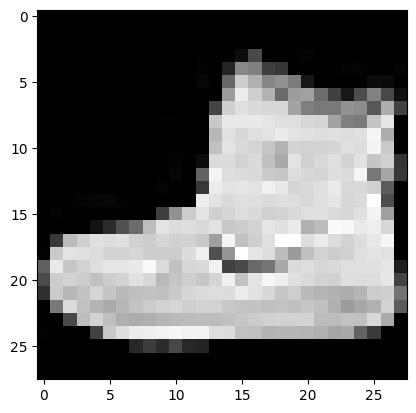

In [2]:
# Define a transform to normalize the data

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)


def load_data(data_dir="./fmnist_data"):
    # Download the train and test data
    trainset = datasets.FashionMNIST(
        data_dir, download=True, train=True, transform=transform
    )
    valset = datasets.FashionMNIST(
        data_dir, download=True, train=False, transform=transform
    )

    return (
        trainset,
        valset,
    )


trainset, valset = load_data()

# Data Loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(valset, batch_size=100, shuffle=True)

# Labels in the data and their corresponding integer mapping
label_mapping = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Report split sizes
print("Training set has {} instances".format(len(trainset)))
print("Validation set has {} instances".format(len(valset)))

# Plotting the image
plt.imshow(trainset[0][0][0], cmap="gray")

## Building the Model

In [24]:
# class LenetCNN(nn.Module):
#     def __init__(self, num_nodes=120, activation_function="relu"):
#         super(LenetCNN, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
#         self.relu1 = nn.ReLU()
#         self.avgpool1 = nn.AvgPool2d(2, stride=2)

#         self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
#         self.relu2 = nn.ReLU()
#         self.avgpool2 = nn.AvgPool2d(2, stride=2)

#         self.fc1 = nn.Linear(in_features=400, out_features=num_nodes)
#         self.relu3 = nn.ReLU()
#         self.fc2 = nn.Linear(in_features=num_nodes, out_features=64)
#         self.relu4 = nn.ReLU()
#         self.fc3 = nn.Linear(in_features=64, out_features=10)

#         # Activation function
#         # if activation_function == "relu":
#         #     self.activation = nn.ReLU()
#         # elif activation_function == "tanh":
#         #     self.activation = nn.Tanh()
#         # else:
#         #     raise ValueError("Unsupported activation function. Use 'relu' or 'tanh'.")

#     def forward(self, x):
#         out = self.conv1(x)
#         out = self.relu1(out)
#         out = self.avgpool1(out)
#         out = self.conv2(out)
#         out = self.relu2(out)
#         out = self.avgpool2(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc1(out)
#         out = self.relu3(out)
#         out = self.fc2(out)
#         out = self.relu4(out)
#         out = self.fc3(out)

#         return out


def LenetCNN():
    model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(in_features=400, out_features=120),
        nn.ReLU(),
        nn.Linear(in_features=120, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=10),
    )
    return model

In [21]:
# validating the model
def validate(model, data):
    total = 0
    correct = 0

    for i, (images, labels) in enumerate(data):
        x = model(images)
        value, pred = torch.max(x, 1)
        total += x.size(0)
        correct += torch.sum(pred == labels)
    print(total, correct)
    return correct * 100 / total

In [29]:
# training function
# model = LenetCNN()
max_accuracy = 0
learning_rate = 1e-3
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


def train(
    # model = LenetCNN(),
    epochs=10,
    criterion=nn.CrossEntropyLoss(),
    # optimizer=optimizer,
    device="cpu",
):
    accuracies = []
    max_accuracy = 0
    model = LenetCNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        for i, (images, labels) in enumerate(trainloader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = model(images)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

        accuracy = float(validate(model, testloader))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(model)
            max_accuracy = accuracy
            print("Saving the best model with accuracy", accuracy)

        print("Epoch :", epoch + 1, "Accuracy :", accuracy, "%")
    train_accuracy = float(validate(model, trainloader))
    print("This is the train accuracy", train_accuracy)
    plt.plot(accuracies)
    return best_model

10000 tensor(7922)
Saving the best model with accuracy 79.22000122070312
Epoch : 1 Accuracy : 79.22000122070312 %
10000 tensor(8455)
Saving the best model with accuracy 84.55000305175781
Epoch : 2 Accuracy : 84.55000305175781 %
10000 tensor(8539)
Saving the best model with accuracy 85.38999938964844
Epoch : 3 Accuracy : 85.38999938964844 %
10000 tensor(8671)
Saving the best model with accuracy 86.70999908447266
Epoch : 4 Accuracy : 86.70999908447266 %
10000 tensor(8704)
Saving the best model with accuracy 87.04000091552734
Epoch : 5 Accuracy : 87.04000091552734 %
10000 tensor(8783)
Saving the best model with accuracy 87.83000183105469
Epoch : 6 Accuracy : 87.83000183105469 %
10000 tensor(8837)
Saving the best model with accuracy 88.37000274658203
Epoch : 7 Accuracy : 88.37000274658203 %
10000 tensor(8879)
Saving the best model with accuracy 88.79000091552734
Epoch : 8 Accuracy : 88.79000091552734 %
10000 tensor(8864)
Epoch : 9 Accuracy : 88.63999938964844 %
10000 tensor(8961)
Saving th

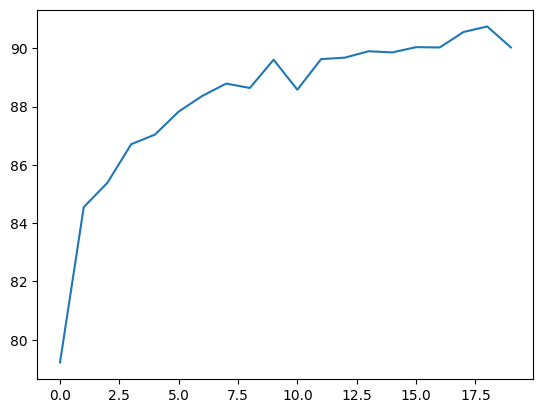

In [30]:
# training the model and saving the best model
timestamp = datetime.now()
lenet_model = train(epochs=20)
model_path = "./saved_models/best_model_{}".format(timestamp)
torch.save(lenet_model.state_dict(), model_path)

Model Test Accuracy : 0.9111
     0    1    2    3    4    5    6    7    8    9
0  845    1   13   15    2    3  113    0    8    0
1    1  984    0    6    1    0    6    0    2    0
2   16    0  865   10   52    0   51    0    6    0
3   13   11   14  911   19    0   24    0    8    0
4    2    0   49   29  841    0   76    0    3    0
5    0    0    0    1    0  983    0    9    0    7
6  100    1   64   16   41    0  764    0   14    0
7    0    0    0    0    0    8    0  978    0   14
8    4    0    1    2    0    0    1    5  987    0
9    0    0    1    0    0    5    0   41    0  953


<Axes: >

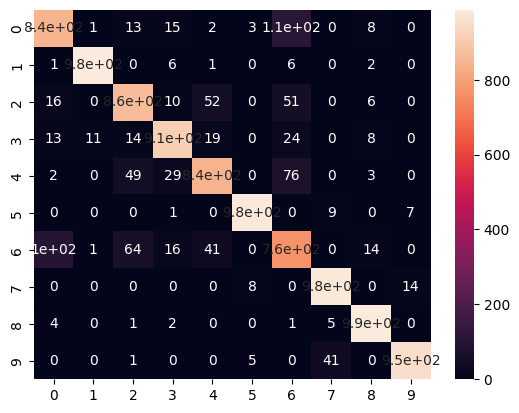

In [121]:
def predict_dataloader(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        x = model(images)
        value, pred = torch.max(x, 1)
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)


y_pred, y_true = predict_dataloader(lenet_model, testloader)
print("Model Test Accuracy :", accuracy_score(y_true=y_true, y_pred=y_pred))
conf_matrix = pd.DataFrame(
    confusion_matrix(y_true=y_true, y_pred=y_pred, labels=np.arange(0, 10))
)
print(conf_matrix)
sns.heatmap(conf_matrix, annot=True)

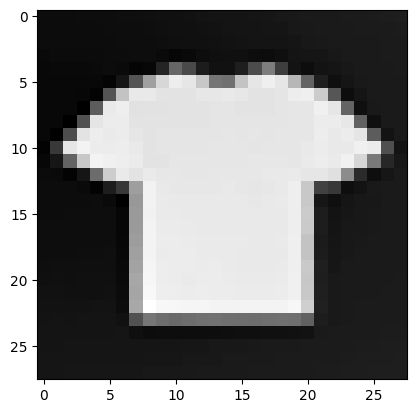

Predicted: T-shirt/Top, Probabiity: 68.47639679908752%


In [265]:
# Testing on out of sample dataset
path = "https://www.mrporter.com/variants/images/3633577411310824/in/w2000_q60.jpg"  # We can use any other image link here


def out_of_sample_image_transformer(path):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        image = Image.open(f).convert(mode="L")
        image = image.resize((28, 28))
        x = (255 - np.expand_dims(np.array(image), -1)) / 255.0
    return x


def out_of_sample_validation(image, model, device=device):
    with torch.no_grad():
        pred = model(torch.unsqueeze(transform(image), axis=1).float().to(device))
        return F.softmax(pred, dim=1).cpu().numpy()


# Displaying the image
def displaying_out_of_sample_image_from_path(path):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        image = Image.open(f).convert(mode="L")
        image = image.resize((28, 28))
        x = (255 - np.expand_dims(np.array(image), -1)) / 255.0
    plt.imshow(x.squeeze(-1), cmap="gray")
    plt.show()


displaying_out_of_sample_image_from_path(path)

# Predicting the out-of-sample image
transformed_image = out_of_sample_image_transformer(path)
out_of_sample_pred = out_of_sample_validation(
    transformed_image, lenet_model, device
)  # Add this to the out_of_sample function above #TODO
pred_id = np.argmax(out_of_sample_pred)
print(
    f"Predicted: {label_mapping[pred_id]}, Probabiity: {out_of_sample_pred[0][pred_id]*100}%"
)

Best Hyperparameters: {'max_epochs': 15, 'module__activation_function': 'tanh', 'module__num_nodes': 64, 'optimizer__lr': 0.01}
Saving the best model with accuracy 84.80000305175781
Epoch : 1 Accuracy : 84.80000305175781 %
Saving the best model with accuracy 86.13999938964844
Epoch : 2 Accuracy : 86.13999938964844 %
Epoch : 3 Accuracy : 85.5999984741211 %
Saving the best model with accuracy 86.51000213623047
Epoch : 4 Accuracy : 86.51000213623047 %
Saving the best model with accuracy 86.94999694824219
Epoch : 5 Accuracy : 86.94999694824219 %
Epoch : 6 Accuracy : 86.70999908447266 %
Saving the best model with accuracy 87.48999786376953
Epoch : 7 Accuracy : 87.48999786376953 %
Epoch : 8 Accuracy : 86.8499984741211 %
Epoch : 9 Accuracy : 86.75 %
Epoch : 10 Accuracy : 85.98999786376953 %
Epoch : 11 Accuracy : 84.94999694824219 %
Epoch : 12 Accuracy : 85.25 %
Epoch : 13 Accuracy : 82.19000244140625 %
Epoch : 14 Accuracy : 82.47000122070312 %
Epoch : 15 Accuracy : 85.4000015258789 %
This is 

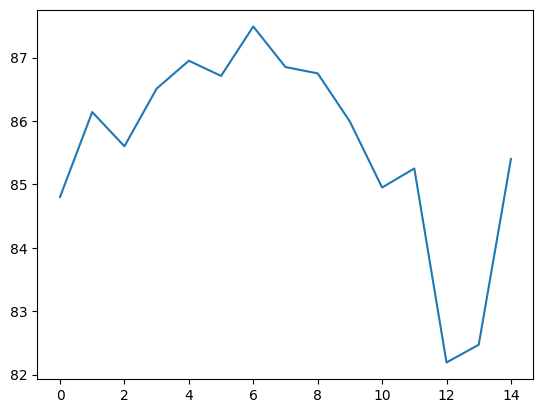

In [62]:
# Hyperparameter tuning


# Define hyperparameters for grid search
# Define the Skorch wrapper

param_grid = {
    # "batch_size": [32, 64, 128],
    "max_epochs": [10, 15, 30],
    "optimizer__lr": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    # 'optimizer__momentum': [0.0, 0.2, 0.4, 0.6, 0.8, 0.9],
    "module__num_nodes": [64, 128, 256],
    "module__activation_function": ["relu", "tanh"],
}

# 'module__activation': [nn.Identity, nn.ReLU, nn.ELU, nn.ReLU6,
#                         nn.GELU, nn.Softplus, nn.Softsign, nn.Tanh,
#                         nn.Sigmoid, nn.Hardsigmoid]

# Define the model, criterion, and optimizer
model = NeuralNetClassifier(
    LenetCNN,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    verbose=False,
    train_split=None,
)
criterion = nn.CrossEntropyLoss()

# Perform grid search
samples, labels = next(iter(trainloader))
grid_search = GridSearchCV(
    estimator=model, param_grid=param_grid, scoring="accuracy", n_jobs=-1, cv=3
)

# grid_search.fit(samples, labels, criterion=criterion, error_score="raise")
grid_search.fit(samples, labels)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model with the best hyperparameters
best_model = LenetCNN(
    num_nodes=best_params["module__num_nodes"],
    activation_function=best_params["module__activation_function"],
)  # You may need to modify this based on your actual model
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params["optimizer__lr"])
trained_model = train(
    model=best_model,
    epochs=best_params["max_epochs"],
    optimizer=optimizer,
    criterion=criterion,
)

Plot the feature maps for the convulution layers

#### LIME 

torch.Size([1, 28, 28])


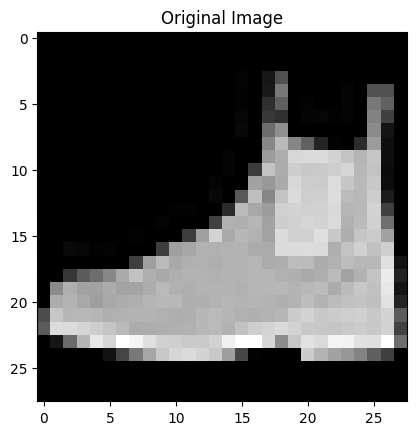

(1, 28, 28)


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


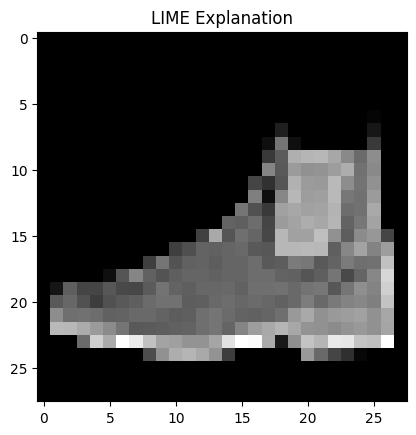

In [258]:
model = lenet_model
# Choose a sample image for explanation
samples, labels = next(iter(testloader))
image = samples[0]
label = int(labels[0].numpy())

plt.imshow(image.squeeze().numpy(), cmap="gray")
plt.title("Original Image")
plt.show()


def predict_fn(img):
    gray_images = rgb2gray(img).reshape(-1, 1, 28, 28)
    outputs = model(torch.from_numpy(gray_images).float())
    probabilities = F.softmax(outputs, dim=1)
    return probabilities.detach().numpy()


explainer = lime_image.LimeImageExplainer()

# Explain the prediction for the sample image
explanation = explainer.explain_instance(
    image.squeeze(0),
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000,
    batch_size=1,
    labels=labels,
)

# Display the LIME explanation
temp, mask = explanation.get_image_and_mask(
    label, positive_only=True, num_features=5, hide_rest=True
)
plt.imshow(mark_boundaries(temp, mask), cmap="gray")
plt.title("LIME Explanation")
plt.show()

torch.Size([1, 1, 28, 28])


  0%|          | 0/1000 [00:00<?, ?it/s]

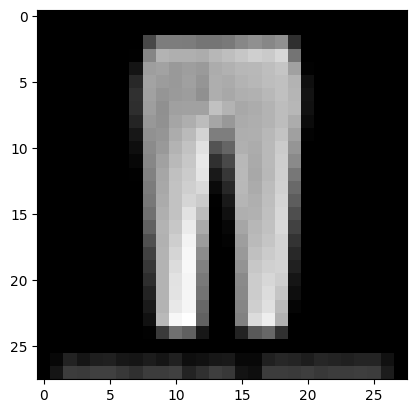

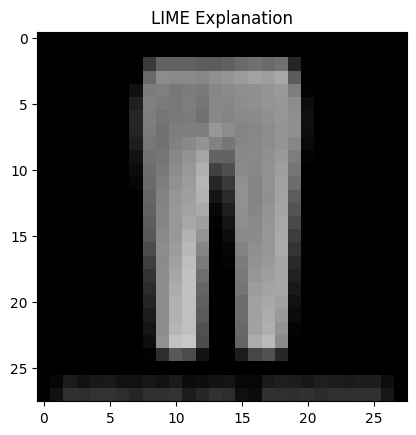

In [264]:
# Choose an out of sample image for explanation
path = "https://www.shutterstock.com/image-photo/light-grey-formal-mens-trousers-260nw-1096296503.jpg"
transformed_image = out_of_sample_image_transformer(path)
prediction = np.argmax(out_of_sample_validation(transformed_image, lenet_model, device))

transformed_image = transformed_image.transpose((2, 0, 1))
explanation = explainer.explain_instance(
    transformed_image.squeeze(0),
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000,
    batch_size=1,
    labels=labels,
)

# Display the LIME explanation
displaying_out_of_sample_image_from_path(path)
temp, mask = explanation.get_image_and_mask(
    prediction, positive_only=True, num_features=5, hide_rest=True
)
plt.imshow(mark_boundaries(temp, mask), cmap="gray")
plt.title("LIME Explanation")
plt.show()

#### SHAP

90 10


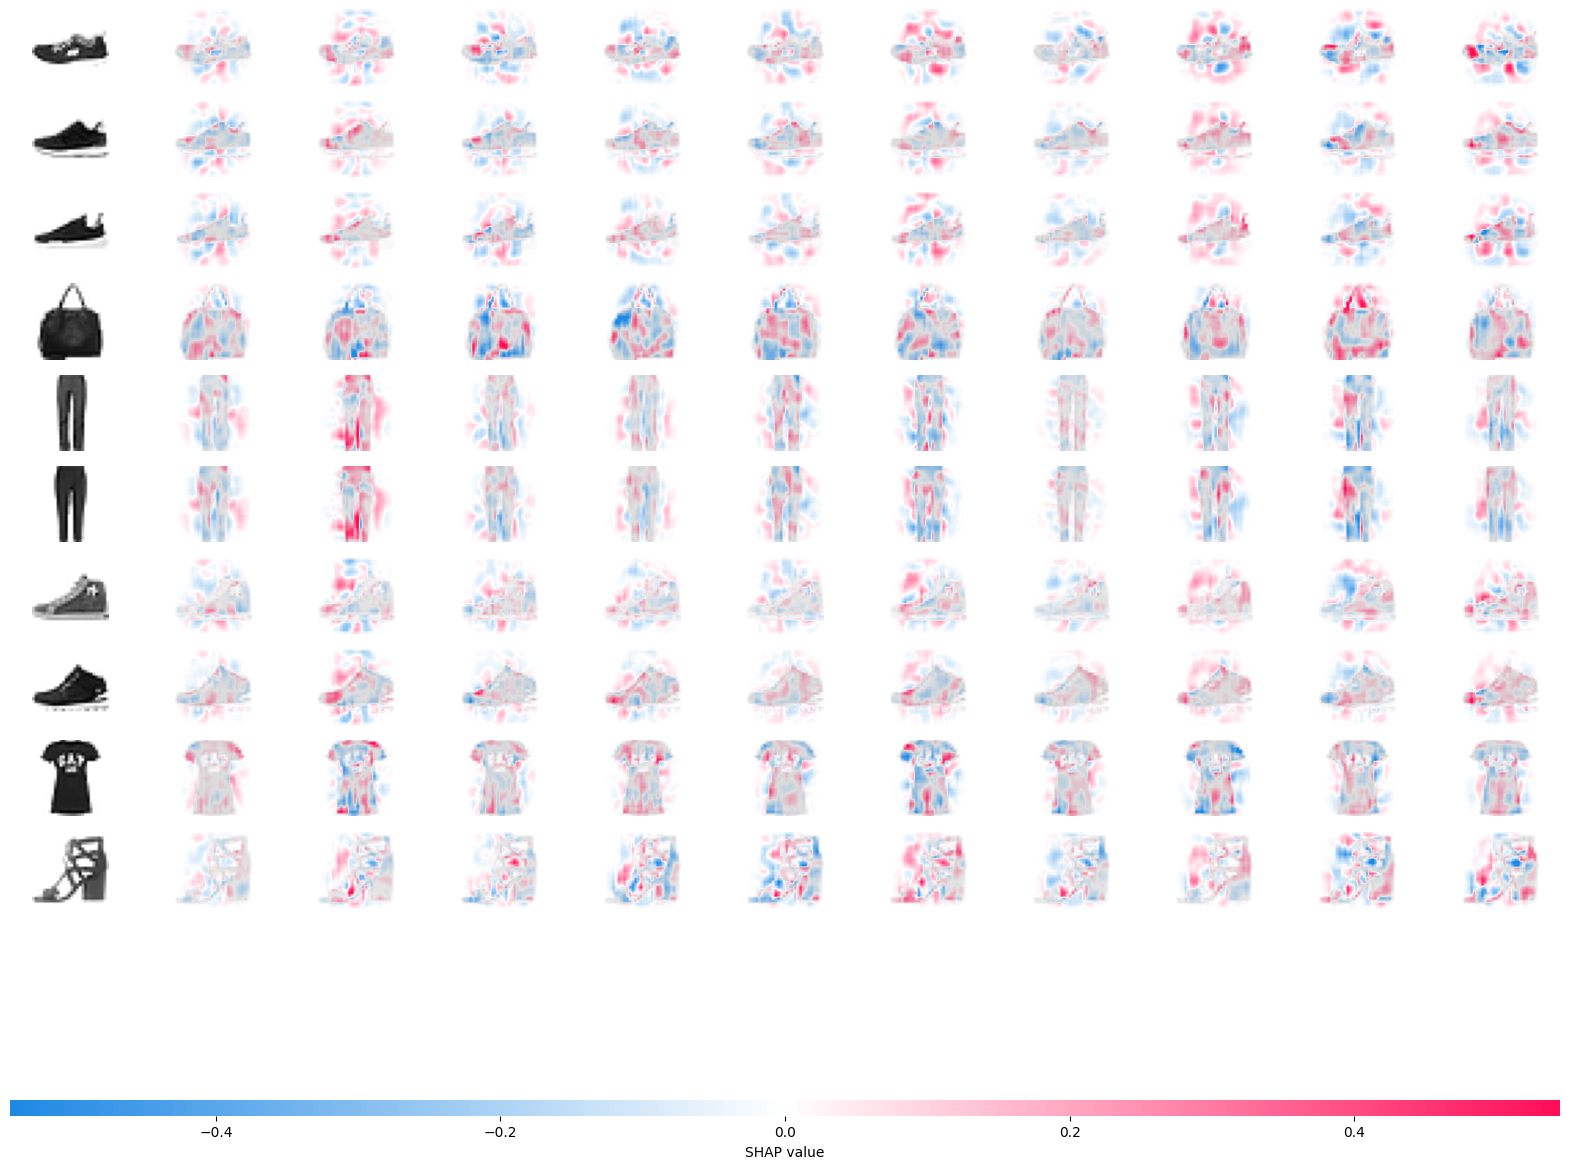

In [129]:
import shap

batch = next(iter(testloader))
img, _ = batch
img = img.view(-1, 1, 28, 28)

background = img[:90]
test_images = img[90:100]

print(len(background), len(test_images))

e = shap.DeepExplainer(model, img)
shap_values = e.shap_values(test_images)


shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, -test_numpy)

# Rough Work

In [82]:
class_correct = [0.0 for _ in range(10)]
total_correct = [0.0 for _ in range(10)]

with torch.no_grad():
    for img, labels in testloader:
        img, labels = img.to(device), labels.to(device)
        test = Variable(img)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()

        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1

for i in range(10):
    print(
        "Accuracy of {}: {:.2f}%".format(
            label_mapping[i], class_correct[i] * 100 / total_correct[i]
        )
    )

Accuracy of T-shirt/Top: 90.80%
Accuracy of Trouser: 96.90%
Accuracy of Pullover: 86.70%
Accuracy of Dress: 89.90%
Accuracy of Coat: 93.80%
Accuracy of Sandal: 97.80%
Accuracy of Shirt: 55.60%
Accuracy of Sneaker: 98.50%
Accuracy of Bag: 98.10%
Accuracy of Ankle Boot: 92.90%
